In [1]:
include("random_clifford/Initial.jl")
include("random_clifford/Symplectic.jl")

reverseCommands (generic function with 1 method)

In [2]:
using Yao
using YaoBlocks
using YaoBlocks.AD
using Random
using PyPlot
using YaoSym
using YaoExtensions
using QuAlgorithmZoo: Adam, update!
using LinearAlgebra
using BenchmarkTools

## Generate a dataset of random clifford circuit and corresponding energy

### Parameters

In [195]:
n_qubits = 2
n_circuits = 200
n = n_qubits;

### Create random circuits

In [196]:
n_clifford_circuits = max(getNumberOfSymplecticCliffords(n), 2^63-1)

9223372036854775807

In [197]:
function parseCommand(command)
    if command[1] == "hadamard"
        return put(command[2]=>H)
    elseif command[1] == "phase"
        return put(command[2]=>shift(π/2))
    elseif command[1] == "cnot"
        return control(command[2][1], command[2][2]=>X)
    else
        error("The command should be either 'hadamard', 'phase' or 'cnot', not $(command[1])")
    end
end

parseCommand (generic function with 1 method)

In [198]:
function getRandomCircuit(i)
    commands = decompose(rand(0:n_clifford_circuits), rand(0:2^(2*n)), n, true)
    list_commands = map(c -> (c[1], parse.(Int, split(c[2], ","))),
                    split.(commands, r"\(|\)", keepempty=false)[2:length(commands)-1])
    circuit = chain(n_qubits, parseCommand.(list_commands))
    print("$(i) ")
    return circuit
end

getRandomCircuit (generic function with 1 method)

In [226]:
list_circuits = [getRandomCircuit(i) for i in 1:n_circuits];

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

In [227]:
ket"00" |> list_circuits[2]

NotImplementedError{Tuple{DataType,ShiftGate{Float64}}}: NotImplementedError: mat is not implemented for (::DataType, ::ShiftGate{Float64}), please implement this method for your custom type

### Create Hamiltonian

In [257]:
W = 1/n * (UnitUpperTriangular(ones(n, n)) - I)

2×2 UpperTriangular{Float64,Array{Float64,2}}:
 0.0  0.5
  ⋅   0.0

In [258]:
function get_hamiltonian(W::AbstractMatrix)
    nbit = size(W, 1)
    ab = Any[]
    for i=1:nbit,j=i+1:nbit
        if W[i,j] != 0
            push!(ab, W[i,j]*repeat(nbit, Z, [i,j]))
        end
    end
    sum(ab)
end

get_hamiltonian (generic function with 1 method)

In [259]:
hamil = get_hamiltonian(W);

In [260]:
function evaluate_hamiltonian(i)
    print(i);
    print(" ")
    expect(hamil, zero_state(n_qubits) |> list_circuits[i])
end

evaluate_hamiltonian (generic function with 1 method)

### Compute the expectation values

In [261]:
state = zero_state(n_qubits) |> list_circuits[1];

In [262]:
energies = evaluate_hamiltonian.(1:n_circuits);

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

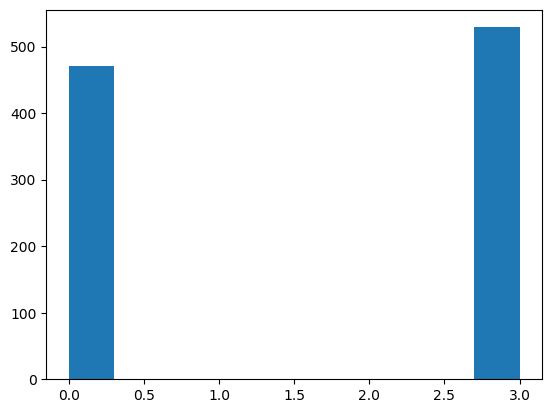

([471.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 529.0], [0.0, 0.3, 0.6, 0.8999999999999999, 1.2, 1.5, 1.7999999999999998, 2.1, 2.4, 2.6999999999999997, 3.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x1524ac860>, PyObject <matplotlib.patches.Rectangle object at 0x151e6ef98>, PyObject <matplotlib.patches.Rectangle object at 0x1524acdd8>, PyObject <matplotlib.patches.Rectangle object at 0x1524acef0>, PyObject <matplotlib.patches.Rectangle object at 0x1525b7438>, PyObject <matplotlib.patches.Rectangle object at 0x1525b7748>, PyObject <matplotlib.patches.Rectangle object at 0x1525b7a58>, PyObject <matplotlib.patches.Rectangle object at 0x1525b7d68>, PyObject <matplotlib.patches.Rectangle object at 0x1525b7e80>, PyObject <matplotlib.patches.Rectangle object at 0x1525c43c8>])

In [263]:
hist(zero_state(n_qubits) |> list_circuits[4] |> r->Yao.measure(r, nshots=1000))

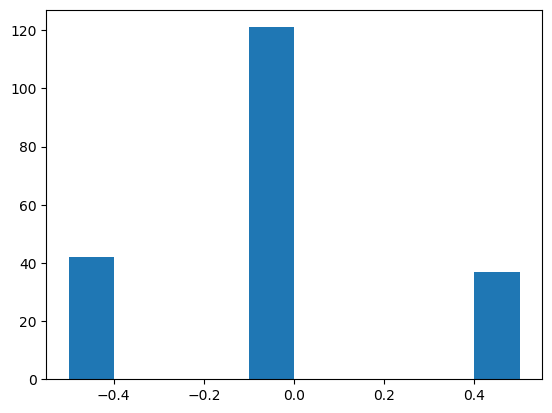

In [264]:
hist(energies);

In [265]:
energies

200-element Array{Complex{Float64},1}:
  -7.498798913309288e-33 + 0.0im
                     0.0 + 0.0im
                     0.5 + 0.0im
      0.4999999999999998 + 0.0im
                     0.0 + 0.0im
 -1.8746997283273213e-33 + 0.0im
   7.498798913309284e-33 + 0.0im
                     0.0 + 0.0im
   7.498798913309284e-33 + 0.0im
                     0.0 + 0.0im
 -3.7493994566546427e-33 + 0.0im
     -0.4999999999999998 + 0.0im
                     0.0 + 0.0im
                         ⋮      
 -3.7493994566546427e-33 + 0.0im
                     0.0 + 0.0im
                     0.0 + 0.0im
                     0.0 + 0.0im
     0.49999999999999967 + 0.0im
     0.49999999999999967 + 0.0im
      0.4999999999999998 + 0.0im
     -0.4999999999999998 + 0.0im
     -0.4999999999999998 + 0.0im
                     0.0 + 0.0im
                     0.0 + 0.0im
                     0.0 + 0.0im

### TODO: create a balanced dataset (in terms of energy)

### TODO: Save the dataset

## Variational circuit

### Definition

In [266]:
function U()
    return chain(Rz(0), Rx(0), Rz(0))
end

U (generic function with 1 method)

In [267]:
list_circuits = NoParams.(list_circuits);

In [268]:
parameters(list_circuits[1])

0-element Array{Float64,1}

In [344]:
v_unitary = chain(n, put(1=>U()), put(2=>U()), 
                  control(2, 1=>X), 
                  put(1=>Rz(0)), put(2=>Ry(0)),
                  control(1, 2=>X),
                  put(2=>Ry(0)),
                  control(2, 1=>X),
                  put(1=>U()), put(2=>U()));

v_circuit = chain(n+1, put(1=>H), control(1, 2:n+1=>v_unitary), put(1=>H));
total_circuits = [chain(n+1, concentrate(n+1, circuit, 2:n+1), v_circuit) for circuit in list_circuits];

In [345]:
parameters(v_unitary)

15-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [346]:
function loss(real_energy, predicted_energy)
    return 1/2 * (real_energy - predicted_energy)^2
end

loss (generic function with 1 method)

In [347]:
expect(put(n+1, 1=>Z), zero_state(n+1) |> total_circuits[1])

0.4999999999999997 + 0.0im

In [348]:
dispatch!.(v_unitary, :random);
a_param = 1
b_param = 0
# optimizer = Adam(lr=0.005)
list_rmse = Any[]
using Flux.Optimise

In [349]:
function predict_energy(i)
    psi = zero_state(n+1) |> total_circuits[i]
    Z1 = put(n+1, 1=>Z)
    return a_param * expect(Z1, psi) + b_param
end

predict_energy (generic function with 1 method)

In [367]:
n_epochs = 2000

lr = 0.01
lr_ab = 0.001
batch_size = 20
optimizer = ADAGrad(lr)
params = parameters(v_unitary)

for epoch = 1:n_epochs
    mse = 0
    gradient_batch = zeros(length(params))
    gradient_a = 0
    gradient_b = 0
    shuffle!(list_circuits)
    for i = 1:n_circuits
        Z1 = put(n+1, 1=>Z)
        residual = predict_energy(i) - energies[i]
        mse += residual^2
        
        grad_input, grad_params = expect'(Z1, zero_state(n+1) => total_circuits[i])
        grad_params *= a_param * residual
        gradient_batch += grad_params
        gradient_a += predict_energy(i) * residual
        gradient_b += residual
#         @show params
        if i % batch_size == 0 || i == n_circuits
            gradient_batch /= batch_size
            gradient_a /= batch_size
            gradient_b /= batch_size
#             dispatch!(v_unitary, params-gradient_batch)
#             params -= 0.0000001 * Float64.(gradient_batch)
            Optimise.update!(optimizer, params, gradient_batch)
            a_param -= lr_ab * gradient_a
            b_param -= lr_ab * gradient_b
            
            dispatch!(v_unitary, params)
            
            gradient_batch = zeros(length(params))
            gradient_a = 0
            gradient_b = 0
        end
    end
    rmse = sqrt(mse / n_circuits)
    push!(list_rmse, rmse)
    println("Epoch $epoch, RMSE = $rmse")
end

Epoch 1, RMSE = 0.30962985330679377 + 0.0im
Epoch 2, RMSE = 0.3095757475482621 + 0.0im
Epoch 3, RMSE = 0.3095671642270659 + 0.0im
Epoch 4, RMSE = 0.3095628637262542 + 0.0im
Epoch 5, RMSE = 0.3095601042424163 + 0.0im
Epoch 6, RMSE = 0.30955810551063734 + 0.0im
Epoch 7, RMSE = 0.30955654871751986 + 0.0im
Epoch 8, RMSE = 0.3095552758972438 + 0.0im
Epoch 9, RMSE = 0.30955419857861793 + 0.0im
Epoch 10, RMSE = 0.30955326279284795 + 0.0im
Epoch 11, RMSE = 0.30955243347067407 + 0.0im
Epoch 12, RMSE = 0.30955168668616834 + 0.0im
Epoch 13, RMSE = 0.30955100547108416 + 0.0im
Epoch 14, RMSE = 0.3095503774056832 + 0.0im
Epoch 15, RMSE = 0.3095497931580018 + 0.0im
Epoch 16, RMSE = 0.30954924555931806 + 0.0im
Epoch 17, RMSE = 0.30954872899749886 + 0.0im
Epoch 18, RMSE = 0.30954823900650225 + 0.0im
Epoch 19, RMSE = 0.3095477719811454 + 0.0im
Epoch 20, RMSE = 0.3095473249742716 + 0.0im
Epoch 21, RMSE = 0.30954689554955017 + 0.0im
Epoch 22, RMSE = 0.3095464816727047 + 0.0im
Epoch 23, RMSE = 0.3095460816

Epoch 184, RMSE = 0.3095100465301523 + 0.0im
Epoch 185, RMSE = 0.3095098675029776 + 0.0im
Epoch 186, RMSE = 0.30950968875423845 + 0.0im
Epoch 187, RMSE = 0.3095095102826265 + 0.0im
Epoch 188, RMSE = 0.30950933208685083 + 0.0im
Epoch 189, RMSE = 0.3095091541656372 + 0.0im
Epoch 190, RMSE = 0.3095089765177275 + 0.0im
Epoch 191, RMSE = 0.3095087991418797 + 0.0im
Epoch 192, RMSE = 0.30950862203686674 + 0.0im
Epoch 193, RMSE = 0.3095084452014772 + 0.0im
Epoch 194, RMSE = 0.30950826863451475 + 0.0im
Epoch 195, RMSE = 0.30950809233479726 + 0.0im
Epoch 196, RMSE = 0.3095079163011568 + 0.0im
Epoch 197, RMSE = 0.3095077405324399 + 0.0im
Epoch 198, RMSE = 0.3095075650275063 + 0.0im
Epoch 199, RMSE = 0.3095073897852294 + 0.0im
Epoch 200, RMSE = 0.30950721480449545 + 0.0im
Epoch 201, RMSE = 0.3095070400842037 + 0.0im
Epoch 202, RMSE = 0.3095068656232664 + 0.0im
Epoch 203, RMSE = 0.30950669142060716 + 0.0im
Epoch 204, RMSE = 0.30950651747516267 + 0.0im
Epoch 205, RMSE = 0.3095063437858813 + 0.0im
Ep

Epoch 365, RMSE = 0.309481328355663 + 0.0im
Epoch 366, RMSE = 0.3094811868973024 + 0.0im
Epoch 367, RMSE = 0.30948104560016676 + 0.0im
Epoch 368, RMSE = 0.3094809044639038 + 0.0im
Epoch 369, RMSE = 0.30948076348816234 + 0.0im
Epoch 370, RMSE = 0.3094806226725938 + 0.0im
Epoch 371, RMSE = 0.30948048201685013 + 0.0im
Epoch 372, RMSE = 0.30948034152058496 + 0.0im
Epoch 373, RMSE = 0.30948020118345393 + 0.0im
Epoch 374, RMSE = 0.30948006100511377 + 0.0im
Epoch 375, RMSE = 0.3094799209852229 + 0.0im
Epoch 376, RMSE = 0.30947978112344093 + 0.0im
Epoch 377, RMSE = 0.30947964141942946 + 0.0im
Epoch 378, RMSE = 0.30947950187285084 + 0.0im
Epoch 379, RMSE = 0.30947936248336927 + 0.0im
Epoch 380, RMSE = 0.30947922325065064 + 0.0im
Epoch 381, RMSE = 0.3094790841743615 + 0.0im
Epoch 382, RMSE = 0.30947894525417086 + 0.0im
Epoch 383, RMSE = 0.3094788064897482 + 0.0im
Epoch 384, RMSE = 0.30947866788076456 + 0.0im
Epoch 385, RMSE = 0.30947852942689325 + 0.0im
Epoch 386, RMSE = 0.3094783911278077 + 0.0

Epoch 546, RMSE = 0.3094580624718432 + 0.0im
Epoch 547, RMSE = 0.30945794561615947 + 0.0im
Epoch 548, RMSE = 0.30945782887592965 + 0.0im
Epoch 549, RMSE = 0.30945771225097346 + 0.0im
Epoch 550, RMSE = 0.3094575957411115 + 0.0im
Epoch 551, RMSE = 0.3094574793461645 + 0.0im
Epoch 552, RMSE = 0.3094573630659538 + 0.0im
Epoch 553, RMSE = 0.30945724690030163 + 0.0im
Epoch 554, RMSE = 0.30945713084903037 + 0.0im
Epoch 555, RMSE = 0.3094570149119632 + 0.0im
Epoch 556, RMSE = 0.3094568990889241 + 0.0im
Epoch 557, RMSE = 0.3094567833797371 + 0.0im
Epoch 558, RMSE = 0.30945666778422715 + 0.0im
Epoch 559, RMSE = 0.3094565523022196 + 0.0im
Epoch 560, RMSE = 0.3094564369335405 + 0.0im
Epoch 561, RMSE = 0.3094563216780162 + 0.0im
Epoch 562, RMSE = 0.309456206535474 + 0.0im
Epoch 563, RMSE = 0.30945609150574144 + 0.0im
Epoch 564, RMSE = 0.3094559765886466 + 0.0im
Epoch 565, RMSE = 0.3094558617840182 + 0.0im
Epoch 566, RMSE = 0.3094557470916857 + 0.0im
Epoch 567, RMSE = 0.30945563251147884 + 0.0im
Epo

Epoch 727, RMSE = 0.3094386388721101 + 0.0im
Epoch 728, RMSE = 0.30943854044914254 + 0.0im
Epoch 729, RMSE = 0.3094384421164737 + 0.0im
Epoch 730, RMSE = 0.3094383438739976 + 0.0im
Epoch 731, RMSE = 0.3094382457216083 + 0.0im
Epoch 732, RMSE = 0.30943814765920014 + 0.0im
Epoch 733, RMSE = 0.30943804968666766 + 0.0im
Epoch 734, RMSE = 0.3094379518039061 + 0.0im
Epoch 735, RMSE = 0.3094378540108104 + 0.0im
Epoch 736, RMSE = 0.3094377563072762 + 0.0im
Epoch 737, RMSE = 0.30943765869319906 + 0.0im
Epoch 738, RMSE = 0.30943756116847493 + 0.0im
Epoch 739, RMSE = 0.30943746373300035 + 0.0im
Epoch 740, RMSE = 0.30943736638667196 + 0.0im
Epoch 741, RMSE = 0.30943726912938624 + 0.0im
Epoch 742, RMSE = 0.3094371719610407 + 0.0im
Epoch 743, RMSE = 0.3094370748815324 + 0.0im
Epoch 744, RMSE = 0.3094369778907591 + 0.0im
Epoch 745, RMSE = 0.3094368809886185 + 0.0im
Epoch 746, RMSE = 0.30943678417500914 + 0.0im
Epoch 747, RMSE = 0.3094366874498293 + 0.0im
Epoch 748, RMSE = 0.3094365908129776 + 0.0im
E

Epoch 908, RMSE = 0.30942220279124993 + 0.0im
Epoch 909, RMSE = 0.3094221192163003 + 0.0im
Epoch 910, RMSE = 0.3094220357161564 + 0.0im
Epoch 911, RMSE = 0.3094219522907491 + 0.0im
Epoch 912, RMSE = 0.30942186894001017 + 0.0im
Epoch 913, RMSE = 0.3094217856638709 + 0.0im
Epoch 914, RMSE = 0.30942170246226347 + 0.0im
Epoch 915, RMSE = 0.3094216193351193 + 0.0im
Epoch 916, RMSE = 0.30942153628237046 + 0.0im
Epoch 917, RMSE = 0.30942145330394943 + 0.0im
Epoch 918, RMSE = 0.3094213703997883 + 0.0im
Epoch 919, RMSE = 0.3094212875698196 + 0.0im
Epoch 920, RMSE = 0.30942120481397606 + 0.0im
Epoch 921, RMSE = 0.3094211221321902 + 0.0im
Epoch 922, RMSE = 0.30942103952439504 + 0.0im
Epoch 923, RMSE = 0.3094209569905236 + 0.0im
Epoch 924, RMSE = 0.30942087453050904 + 0.0im
Epoch 925, RMSE = 0.3094207921442848 + 0.0im
Epoch 926, RMSE = 0.3094207098317844 + 0.0im
Epoch 927, RMSE = 0.3094206275929414 + 0.0im
Epoch 928, RMSE = 0.3094205454276894 + 0.0im
Epoch 929, RMSE = 0.30942046333596246 + 0.0im
E

Epoch 1087, RMSE = 0.30940837556519046 + 0.0im
Epoch 1088, RMSE = 0.3094083044085806 + 0.0im
Epoch 1089, RMSE = 0.30940823331646927 + 0.0im
Epoch 1090, RMSE = 0.3094081622888083 + 0.0im
Epoch 1091, RMSE = 0.3094080913255497 + 0.0im
Epoch 1092, RMSE = 0.3094080204266457 + 0.0im
Epoch 1093, RMSE = 0.30940794959204787 + 0.0im
Epoch 1094, RMSE = 0.3094078788217085 + 0.0im
Epoch 1095, RMSE = 0.30940780811558016 + 0.0im
Epoch 1096, RMSE = 0.30940773747361466 + 0.0im
Epoch 1097, RMSE = 0.3094076668957649 + 0.0im
Epoch 1098, RMSE = 0.3094075963819829 + 0.0im
Epoch 1099, RMSE = 0.30940752593222154 + 0.0im
Epoch 1100, RMSE = 0.3094074555464335 + 0.0im
Epoch 1101, RMSE = 0.30940738522457123 + 0.0im
Epoch 1102, RMSE = 0.309407314966588 + 0.0im
Epoch 1103, RMSE = 0.3094072447724363 + 0.0im
Epoch 1104, RMSE = 0.30940717464206957 + 0.0im
Epoch 1105, RMSE = 0.30940710457544035 + 0.0im
Epoch 1106, RMSE = 0.3094070345725022 + 0.0im
Epoch 1107, RMSE = 0.30940696463320816 + 0.0im
Epoch 1108, RMSE = 0.3094

Epoch 1264, RMSE = 0.30939674479857054 + 0.0im
Epoch 1265, RMSE = 0.3093966843774367 + 0.0im
Epoch 1266, RMSE = 0.30939662401342427 + 0.0im
Epoch 1267, RMSE = 0.3093965637064969 + 0.0im
Epoch 1268, RMSE = 0.3093965034566186 + 0.0im
Epoch 1269, RMSE = 0.3093964432637533 + 0.0im
Epoch 1270, RMSE = 0.3093963831278655 + 0.0im
Epoch 1271, RMSE = 0.3093963230489188 + 0.0im
Epoch 1272, RMSE = 0.30939626302687795 + 0.0im
Epoch 1273, RMSE = 0.30939620306170684 + 0.0im
Epoch 1274, RMSE = 0.30939614315336983 + 0.0im
Epoch 1275, RMSE = 0.3093960833018315 + 0.0im
Epoch 1276, RMSE = 0.3093960235070558 + 0.0im
Epoch 1277, RMSE = 0.30939596376900796 + 0.0im
Epoch 1278, RMSE = 0.30939590408765166 + 0.0im
Epoch 1279, RMSE = 0.30939584446295215 + 0.0im
Epoch 1280, RMSE = 0.3093957848948735 + 0.0im
Epoch 1281, RMSE = 0.3093957253833808 + 0.0im
Epoch 1282, RMSE = 0.30939566592843853 + 0.0im
Epoch 1283, RMSE = 0.30939560653001175 + 0.0im
Epoch 1284, RMSE = 0.309395547188065 + 0.0im
Epoch 1285, RMSE = 0.3093

Epoch 1441, RMSE = 0.3093869091600935 + 0.0im
Epoch 1442, RMSE = 0.3093868583315825 + 0.0im
Epoch 1443, RMSE = 0.3093868075545364 + 0.0im
Epoch 1444, RMSE = 0.30938675682892675 + 0.0im
Epoch 1445, RMSE = 0.30938670615472535 + 0.0im
Epoch 1446, RMSE = 0.30938665553190375 + 0.0im
Epoch 1447, RMSE = 0.30938660496043413 + 0.0im
Epoch 1448, RMSE = 0.309386554440288 + 0.0im
Epoch 1449, RMSE = 0.3093865039714371 + 0.0im
Epoch 1450, RMSE = 0.30938645355385336 + 0.0im
Epoch 1451, RMSE = 0.3093864031875085 + 0.0im
Epoch 1452, RMSE = 0.30938635287237476 + 0.0im
Epoch 1453, RMSE = 0.30938630260842387 + 0.0im
Epoch 1454, RMSE = 0.30938625239562806 + 0.0im
Epoch 1455, RMSE = 0.30938620223395913 + 0.0im
Epoch 1456, RMSE = 0.30938615212338916 + 0.0im
Epoch 1457, RMSE = 0.3093861020638903 + 0.0im
Epoch 1458, RMSE = 0.3093860520554347 + 0.0im
Epoch 1459, RMSE = 0.3093860020979945 + 0.0im
Epoch 1460, RMSE = 0.309385952191542 + 0.0im
Epoch 1461, RMSE = 0.30938590233604907 + 0.0im
Epoch 1462, RMSE = 0.3093

Epoch 1618, RMSE = 0.30937868965198595 + 0.0im
Epoch 1619, RMSE = 0.3093786475200736 + 0.0im
Epoch 1620, RMSE = 0.3093786054350888 + 0.0im
Epoch 1621, RMSE = 0.3093785633970079 + 0.0im
Epoch 1622, RMSE = 0.30937852140580796 + 0.0im
Epoch 1623, RMSE = 0.3093784794614656 + 0.0im
Epoch 1624, RMSE = 0.3093784375639579 + 0.0im
Epoch 1625, RMSE = 0.30937839571326187 + 0.0im
Epoch 1626, RMSE = 0.30937835390935414 + 0.0im
Epoch 1627, RMSE = 0.30937831215221173 + 0.0im
Epoch 1628, RMSE = 0.3093782704418115 + 0.0im
Epoch 1629, RMSE = 0.30937822877813054 + 0.0im
Epoch 1630, RMSE = 0.30937818716114573 + 0.0im
Epoch 1631, RMSE = 0.3093781455908341 + 0.0im
Epoch 1632, RMSE = 0.3093781040671728 + 0.0im
Epoch 1633, RMSE = 0.3093780625901391 + 0.0im
Epoch 1634, RMSE = 0.3093780211597095 + 0.0im
Epoch 1635, RMSE = 0.3093779797758615 + 0.0im
Epoch 1636, RMSE = 0.3093779384385723 + 0.0im
Epoch 1637, RMSE = 0.3093778971478188 + 0.0im
Epoch 1638, RMSE = 0.3093778559035784 + 0.0im
Epoch 1639, RMSE = 0.309377

Epoch 1795, RMSE = 0.3093719430287581 + 0.0im
Epoch 1796, RMSE = 0.30937190886124866 + 0.0im
Epoch 1797, RMSE = 0.3093718747368885 + 0.0im
Epoch 1798, RMSE = 0.30937184065565826 + 0.0im
Epoch 1799, RMSE = 0.30937180661753805 + 0.0im
Epoch 1800, RMSE = 0.3093717726225084 + 0.0im
Epoch 1801, RMSE = 0.3093717386705502 + 0.0im
Epoch 1802, RMSE = 0.30937170476164283 + 0.0im
Epoch 1803, RMSE = 0.30937167089576756 + 0.0im
Epoch 1804, RMSE = 0.30937163707290455 + 0.0im
Epoch 1805, RMSE = 0.30937160329303415 + 0.0im
Epoch 1806, RMSE = 0.30937156955613687 + 0.0im
Epoch 1807, RMSE = 0.3093715358621933 + 0.0im
Epoch 1808, RMSE = 0.30937150221118404 + 0.0im
Epoch 1809, RMSE = 0.3093714686030894 + 0.0im
Epoch 1810, RMSE = 0.30937143503789016 + 0.0im
Epoch 1811, RMSE = 0.30937140151556664 + 0.0im
Epoch 1812, RMSE = 0.30937136803609955 + 0.0im
Epoch 1813, RMSE = 0.3093713345994694 + 0.0im
Epoch 1814, RMSE = 0.309371301205657 + 0.0im
Epoch 1815, RMSE = 0.3093712678546427 + 0.0im
Epoch 1816, RMSE = 0.30

Epoch 1972, RMSE = 0.30936655024317733 + 0.0im
Epoch 1973, RMSE = 0.30936652342114696 + 0.0im
Epoch 1974, RMSE = 0.30936649663902405 + 0.0im
Epoch 1975, RMSE = 0.3093664698967912 + 0.0im
Epoch 1976, RMSE = 0.3093664431944316 + 0.0im
Epoch 1977, RMSE = 0.309366416531928 + 0.0im
Epoch 1978, RMSE = 0.3093663899092632 + 0.0im
Epoch 1979, RMSE = 0.30936636332642037 + 0.0im
Epoch 1980, RMSE = 0.3093663367833827 + 0.0im
Epoch 1981, RMSE = 0.30936631028013256 + 0.0im
Epoch 1982, RMSE = 0.3093662838166533 + 0.0im
Epoch 1983, RMSE = 0.30936625739292806 + 0.0im
Epoch 1984, RMSE = 0.3093662310089397 + 0.0im
Epoch 1985, RMSE = 0.30936620466467096 + 0.0im
Epoch 1986, RMSE = 0.3093661783601053 + 0.0im
Epoch 1987, RMSE = 0.30936615209522556 + 0.0im
Epoch 1988, RMSE = 0.3093661258700148 + 0.0im
Epoch 1989, RMSE = 0.30936609968445616 + 0.0im
Epoch 1990, RMSE = 0.30936607353853274 + 0.0im
Epoch 1991, RMSE = 0.3093660474322276 + 0.0im
Epoch 1992, RMSE = 0.3093660213655237 + 0.0im
Epoch 1993, RMSE = 0.3093

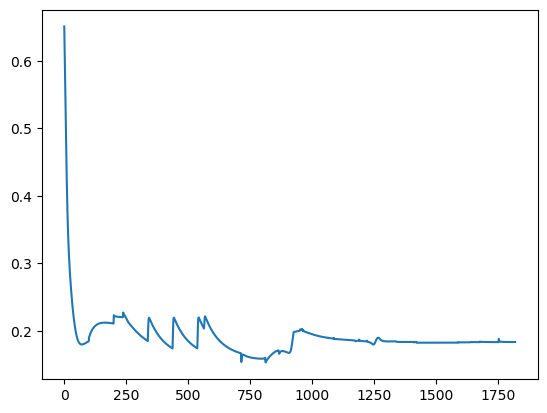

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x152a66a90>

In [343]:
plt.plot(list_rmse[1:end])

## Test

In [303]:
i = 15

psi = zero_state(n+1) |> total_circuits[i]
Z1 = put(n+1, 1=>Z)
println("Predicted Energy: $(expect(Z1, psi))")
println("Real Energy: $(energies[i])")

Predicted Energy: 0.4315397404943842 + 0.0im
Real Energy: 0.49999999999999967 + 0.0im


In [306]:
b_param

0.011158029215652126 - 0.0im

In [358]:
a_param

0.11204233451280095 - 0.0im